In [2]:
# import itk
import sys
import SimpleITK as sitk
import os
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, fixed
import math

from scipy.interpolate import RegularGridInterpolator, interpn

from skimage import measure
from mayavi import mlab
# ipython --gui=qt/
# mlab.init_notebook()

import pylab as pl
import trimesh
from stl import mesh
import re


In [3]:
path = "/Users/janelameski/Desktop/jane/Thesis/"
path_to_normal_deformed = path + "normal_and_deformed/"
path_to_point_clouds = path + "point_clouds/"

In [4]:
import numpy as np
from matplotlib import cm

popi_body_label = 0
popi_air_label = 1
popi_lung_label = 2

def read_POPI_points(file_name):
    """
    Read the Point-validated Pixel-based Breathing Thorax Model (POPI) landmark points file.
    The file is an ASCII file with X Y Z coordinates in each line and the first line is a header.

    Args:
       file_name: full path to the file.
    Returns:
       (list(tuple)): List of points as tuples.
    """
    with open(file_name,'r') as fp:
        lines = fp.readlines()
        points = []
        # First line in the file is #X Y Z which we ignore.
        for line in lines[1:]:
            coordinates = line.split()
            if coordinates:
                points.append((float(coordinates[0]), float(coordinates[1]), float(coordinates[2])))
        return points


def point2str(point, precision=1):
    """
    Format a point for printing, based on specified precision with trailing zeros. Uniform printing for vector-like data 
    (tuple, numpy array, list).
    
    Args:
        point (vector-like): nD point with floating point coordinates.
        precision (int): Number of digits after the decimal point.
    Return:
        String represntation of the given point "xx.xxx yy.yyy zz.zzz...".
    """
    return ' '.join(format(c, '.{0}f'.format(precision)) for c in point)


def uniform_random_points(bounds, num_points):
    """
    Generate random (uniform withing bounds) nD point cloud. Dimension is based on the number of pairs in the bounds input.
    
    Args:
        bounds (list(tuple-like)): list where each tuple defines the coordinate bounds.
        num_points (int): number of points to generate.
    
    Returns:
        list containing num_points numpy arrays whose coordinates are within the given bounds.
    """
    internal_bounds = [sorted(b) for b in bounds]
         # Generate rows for each of the coordinates according to the given bounds, stack into an array, 
         # and split into a list of points.
    mat = np.vstack([np.random.uniform(b[0], b[1], num_points) for b in internal_bounds])
    return list(mat[:len(bounds)].T)


def target_registration_errors(tx, point_list, reference_point_list,
                               display_errors = False, min_err= None, max_err=None, figure_size=(8,6)):
    """
    Distances between points transformed by the given transformation and their
    location in another coordinate system. When the points are only used to
    evaluate registration accuracy (not used in the registration) this is the
    Target Registration Error (TRE).

    Args:
      tx (SimpleITK.Transform): The transform we want to evaluate.
      point_list (list(tuple-like)): Points in fixed image
                                     cooredinate system.
      reference_point_list (list(tuple-like)): Points in moving image
                                               cooredinate system.
      display_errors (boolean): Display a 3D figure with the points from
                                point_list color corresponding to the error.
      min_err, max_err (float): color range is linearly stretched between min_err
                                and max_err. If these values are not given then
                                the range of errors computed from the data is used.
      figure_size (tuple): Figure size in inches.

    Returns:
    (errors) [float]: list of TRE values.
    """
    transformed_point_list = [tx.TransformPoint(p) for p in point_list]

    errors = [np.linalg.norm(np.array(p_fixed) -  np.array(p_moving))
            for p_fixed,p_moving in zip(transformed_point_list, reference_point_list)]
    if display_errors:
        from mpl_toolkits.mplot3d import Axes3D
        import matplotlib.pyplot as plt
        import matplotlib
        fig = plt.figure(figsize=figure_size)
        ax = fig.add_subplot(111, projection='3d')
        if not min_err:
          min_err = np.min(errors)
        if not max_err:
          max_err = np.max(errors)

        collection = ax.scatter(list(np.array(point_list).T)[0],
                              list(np.array(point_list).T)[1],
                              list(np.array(point_list).T)[2],
                              marker = 'o',
                              c = errors,
                              vmin = min_err,
                              vmax = max_err,
                              cmap = matplotlib.cm.hot,
                              label = 'original points')
        plt.colorbar(collection, shrink=0.8)
        plt.title('registration errors in mm', x=0.7, y=1.05)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.show()

    return errors



def print_transformation_differences(tx1, tx2):
    """
    Check whether two transformations are "equivalent" in an arbitrary spatial region 
    either 3D or 2D, [x=(-10,10), y=(-100,100), z=(-1000,1000)]. This is just a sanity check, 
    as we are just looking at the effect of the transformations on a random set of points in
    the region.
    """
    if tx1.GetDimension()==2 and tx2.GetDimension()==2:
        bounds = [(-10,10),(-100,100)]
    elif tx1.GetDimension()==3 and tx2.GetDimension()==3:
        bounds = [(-10,10),(-100,100), (-1000,1000)]
    else:
        raise ValueError('Transformation dimensions mismatch, or unsupported transformation dimensionality')
    num_points = 10
    point_list = uniform_random_points(bounds, num_points)
    tx1_point_list = [ tx1.TransformPoint(p) for p in point_list]
    differences = target_registration_errors(tx2, point_list, tx1_point_list)
    print('Differences - min: {:.2f}, max: {:.2f}, mean: {:.2f}, std: {:.2f}'.format(np.min(differences), np.max(differences), np.mean(differences), np.std(differences)))


def display_displacement_scaling_effect_3d(s, original_x_mat, original_y_mat, original_z_mat, tx, original_control_point_displacements):
    """
    This function displays the effects of the deformable transformation on a grid of points by scaling the
    initial displacements (either of control points for BSpline or the deformation field itself). It does
    assume that all points are contained in the range(-2.5,-2.5), (2.5,2.5).
    """
    if tx.GetDimension() !=3:
        raise ValueError('display_displacement_scaling_effect only works in 2D')
    
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(original_x_mat,
                original_y_mat,
                original_z_mat,
                marker='o', 
                color='blue', label='original points')
    pointsX = []
    pointsY = []
    pointsZ = []
    tx.SetParameters(s*original_control_point_displacements)
  
    for index, value in np.ndenumerate(original_x_mat):
        px,py,pz = tx.TransformPoint((value, original_y_mat[index], original_z_mat[index]))
        pointsX.append(px)
        pointsY.append(py)
        pointsZ.append(pz)
        
    ax.scatter(pointsX,
                pointsY,
                pointsZ,
                marker='^', 
                color='red', label='transformed points')
    ax.legend(loc=(0.25,1.01))
    ax.set_xlim((-3,3))
    ax.set_ylim((-3,3))
    ax.set_zlim((-3,3))
    
def display_displacement_scaling_effect(s, original_x_mat, original_y_mat, tx, original_control_point_displacements):
    """
    This function displays the effects of the deformable transformation on a grid of points by scaling the
    initial displacements (either of control points for BSpline or the deformation field itself). It does
    assume that all points are contained in the range(-2.5,-2.5), (2.5,2.5).
    """
    if tx.GetDimension() !=2:
        raise ValueError('display_displacement_scaling_effect only works in 2D')

    plt.scatter(original_x_mat,
                original_y_mat,
                marker='o', 
                color='blue', label='original points')
    pointsX = []
    pointsY = []
    tx.SetParameters(original_control_point_displacements)
  
    for index, value in np.ndenumerate(original_x_mat):
        px,py = tx.TransformPoint((value, original_y_mat[index]))
        pointsX.append(px) 
        pointsY.append(py)
     
    plt.scatter(pointsX,
                pointsY,
                marker='^', 
                color='red', label='transformed points')
    plt.legend(loc=(0.25,1.01))
    plt.xlim((-2.5,2.5))
    plt.ylim((-2.5,2.5))

def parameter_space_regular_grid_sampling(*transformation_parameters):
    '''
    Create a list representing a regular sampling of the parameter space.
    Args:
        *transformation_paramters : two or more numpy ndarrays representing parameter values. The order
                                    of the arrays should match the ordering of the SimpleITK transformation
                                    parameterization (e.g. Similarity2DTransform: scaling, rotation, tx, ty)
    Return:
        List of lists representing the regular grid sampling.

    Examples:
        #parameterization for 2D translation transform (tx,ty): [[1.0,1.0], [1.5,1.0], [2.0,1.0]]
        >>>> parameter_space_regular_grid_sampling(np.linspace(1.0,2.0,3), np.linspace(1.0,1.0,1))
    '''
    return [[np.asscalar(p) for p in parameter_values]
            for parameter_values in np.nditer(np.meshgrid(*transformation_parameters))]


def similarity3D_parameter_space_regular_sampling(thetaX, thetaY, thetaZ, tx, ty, tz, scale):
    '''
    Create a list representing a regular sampling of the 3D similarity transformation parameter space. As the
    SimpleITK rotation parameterization uses the vector portion of a versor we don't have an
    intuitive way of specifying rotations. We therefor use the ZYX Euler angle parametrization and convert to
    versor.
    Args:
        thetaX, thetaY, thetaZ: numpy ndarrays with the Euler angle values to use.
        tx, ty, tz: numpy ndarrays with the translation values to use.
        scale: numpy array with the scale values to use.
    Return:
        List of lists representing the parameter space sampling (vx,vy,vz,tx,ty,tz,s).
    '''
    return [list(eul2quat(parameter_values[0],parameter_values[1], parameter_values[2])) +
            [np.asscalar(p) for p in parameter_values[3:]] for parameter_values in np.nditer(np.meshgrid(thetaX, thetaY, thetaZ, tx, ty, tz, scale))]


def eul2quat(ax, ay, az, atol=1e-8):
    '''
    Translate between Euler angle (ZYX) order and quaternion representation of a rotation.
    Args:
        ax: X rotation angle in radians.
        ay: Y rotation angle in radians.
        az: Z rotation angle in radians.
        atol: tolerance used for stable quaternion computation (qs==0 within this tolerance).
    Return:
        Numpy array with three entries representing the vectorial component of the quaternion.

    '''
    # Create rotation matrix using ZYX Euler angles and then compute quaternion using entries.
    cx = np.cos(ax)
    cy = np.cos(ay)
    cz = np.cos(az)
    sx = np.sin(ax)
    sy = np.sin(ay)
    sz = np.sin(az)
    r=np.zeros((3,3))
    r[0,0] = cz*cy
    r[0,1] = cz*sy*sx - sz*cx
    r[0,2] = cz*sy*cx+sz*sx

    r[1,0] = sz*cy
    r[1,1] = sz*sy*sx + cz*cx
    r[1,2] = sz*sy*cx - cz*sx

    r[2,0] = -sy
    r[2,1] = cy*sx
    r[2,2] = cy*cx

    # Compute quaternion:
    qs = 0.5*np.sqrt(r[0,0] + r[1,1] + r[2,2] + 1)
    qv = np.zeros(3)
    # If the scalar component of the quaternion is close to zero, we
    # compute the vector part using a numerically stable approach
    if np.isclose(qs,0.0,atol):
        i= np.argmax([r[0,0], r[1,1], r[2,2]])
        j = (i+1)%3
        k = (j+1)%3
        w = np.sqrt(r[i,i] - r[j,j] - r[k,k] + 1)
        qv[i] = 0.5*w
        qv[j] = (r[i,j] + r[j,i])/(2*w)
        qv[k] = (r[i,k] + r[k,i])/(2*w)
    else:
        denom = 4*qs
        qv[0] = (r[2,1] - r[1,2])/denom;
        qv[1] = (r[0,2] - r[2,0])/denom;
        qv[2] = (r[1,0] - r[0,1])/denom;
    return qv

def normalize(arr):
    arr_min = np.min(arr)
    return (arr-arr_min)/(np.max(arr)-arr_min)

def show_histogram(values):
    n, bins, patches = plt.hist(values.reshape(-1), 50, density=True)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    for c, p in zip(normalize(bin_centers), patches):
        plt.setp(p, 'facecolor', cm.viridis(c))

    plt.show()

def explode(data):
    shape_arr = np.array(data.shape)
    size = shape_arr[:3]*2 - 1
    exploded = np.zeros(np.concatenate([size, shape_arr[3:]]), dtype=data.dtype)
    exploded[::2, ::2, ::2] = data
    return exploded

def expand_coordinates(indices):
    x, y, z = indices
    x[1::2, :, :] += 1
    y[:, 1::2, :] += 1
    z[:, :, 1::2] += 1
    return x, y, z

def plot_cube(cube, angle=320):
    """
        plot a point cloud in cube-like shaped points
    """
    cube = normalize(cube)
    
    facecolors = cm.viridis(cube)
    facecolors[:,:,:,-1] = cube
    facecolors = explode(facecolors)
    
    filled = facecolors[:,:,:,-1] != 0
    x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

    fig = plt.figure(figsize=(30/2.54, 30/2.54))
    ax = fig.gca(projection='3d')
    ax.view_init(30, angle)
    ax.set_xlim(right=IMG_DIM*2)
    ax.set_ylim(top=IMG_DIM*2)
    ax.set_zlim(top=IMG_DIM*2)
    
    ax.voxels(x, y, z, filled, facecolors=facecolors, shade=False)
    plt.show()
    
def downsamplePatient(patient_CT, resize_factor):
    """
        downsample an input sitk image by a resize factor
    """
    original_CT = patient_CT#sitk.ReadImage(patient_CT,sitk.sitkInt32)
    dimension = original_CT.GetDimension()
    reference_physical_size = np.zeros(original_CT.GetDimension())
    reference_physical_size[:] = [(sz-1)*spc if sz*spc>mx  else mx for sz,spc,mx in zip(original_CT.GetSize(), original_CT.GetSpacing(), reference_physical_size)]
    
    reference_origin = original_CT.GetOrigin()
    reference_direction = original_CT.GetDirection()

    reference_size = [round(sz/resize_factor) for sz in original_CT.GetSize()] 
    reference_spacing = [ phys_sz/(sz-1) for sz,phys_sz in zip(reference_size, reference_physical_size) ]

    reference_image = sitk.Image(reference_size, original_CT.GetPixelIDValue())
    reference_image.SetOrigin(reference_origin)
    reference_image.SetSpacing(reference_spacing)
    reference_image.SetDirection(reference_direction)

    reference_center = np.array(reference_image.TransformContinuousIndexToPhysicalPoint(np.array(reference_image.GetSize())/2.0))
    
    transform = sitk.AffineTransform(dimension)
    transform.SetMatrix(original_CT.GetDirection())

    transform.SetTranslation(np.array(original_CT.GetOrigin()) - reference_origin)
  
    centering_transform = sitk.TranslationTransform(dimension)
    img_center = np.array(original_CT.TransformContinuousIndexToPhysicalPoint(np.array(original_CT.GetSize())/2.0))
    centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - reference_center))
    centered_transform = sitk.CompositeTransform(transform)
    centered_transform.AddTransform(centering_transform)

    # sitk.Show(sitk.Resample(original_CT, reference_image, centered_transform, sitk.sitkLinear, 0.0))
    
    return sitk.Resample(original_CT, reference_image, centered_transform, sitk.sitkLinear, 0.0)

In [5]:
#get the required file lists from the folders 
file_list = []
for file in os.listdir(path_to_normal_deformed):
    if file.endswith(".mhd"):
        file_list.append(os.path.join(path_to_normal_deformed, file))


pc_file_list = [] 
for file in os.listdir(path_to_point_clouds):
    if file.endswith(".txt"):
        pc_file_list.append(os.path.join(path_to_point_clouds, file))
# print(sorted(pc_file_list)) #flow source target

file_list = sorted(file_list)
files_mr = sorted([a for a in file_list if "_mr_tree" in a])
# print(files_mr)
files_trus = sorted([a for a in file_list if "_trus_tree" in a])
# files_to_deform = sorted([a for a in file_list if "_mr_tree." in a or "_trus_tree." in a])

In [6]:
def plot_mlab(im):   
    """
    plot mhd loaded image using Myavi library
    """
    mlab.contour3d(im)
    mlab.draw()
    mlab.show()
    
def get_mesh(im):
    """
    get the mesh from an 3D image
    """
    verts, faces, normals, values = measure.marching_cubes(im)
    
    return trimesh.Trimesh(vertices = verts, faces = faces)
    
def get_surface_pc(im):
    """
    get surface pointcloud of image

    """    
    verts, faces, normals, values = measure.marching_cubes(im)
    
    for i in range(len(verts)):
        verts[i] = [math.ceil(x) for x in verts[i]]
    return np.unique(verts, axis=0)

def get_pc(im):
    """
    Get pointcloud of image
    """

    a = np.argwhere(im!=0)
    return a

In [7]:
#
def create_pointclouds(file_list):
    """create pointcloud files"""
    for p in file_list:
        print(p)
        im = sitk.ReadImage(p)
        im = sitk.GetArrayFromImage(im)
        pc = get_pc(im)
        np.savetxt(path_to_point_clouds + p[46:-4]+"_pc.txt", pc)
    

In [8]:
#prepare data set
def centeroidnp(arr):
    """get the centroid of a pointcloud"""
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    sum_z = np.sum(arr[:, 2])
    return math.ceil(sum_x/length), \
            math.ceil(sum_y/length), \
            math.ceil(sum_z/length)

def append_m(path):
    """append a binary label as a last dimension of a pointcloud
        to represent if the point is on the surface (1) or not(0)"""
    img_mhd = sitk.ReadImage(path)
    im = sitk.GetArrayFromImage(img_mhd)
    return append_m_image(im)

def append_m_image(im): 
    a1 = get_pc(im)
    a2 = get_surface_pc(im)
    a1_rows = set(map(tuple, a1))
    a2_rows = set(map(tuple, a2))
    inner = np.array(list(a1_rows.difference(a2_rows)))
    outer = np.array(list(a1_rows.intersection(a2_rows)))
    inner_pc = np.c_[inner, np.zeros(len(inner))]
    surface_pc = np.c_[outer, np.ones(len(outer))]
    return np.concatenate([inner_pc, surface_pc])




In [9]:
def create_7D(source_pc, source_center, target_center):
    """create a 7D pointcloud as explained in Fu et al."""
    v_s = np.zeros((len(source_pc), 7))
    for i in range(len(v_s)):
        v_ss = source_center - source_pc[i,:3]
        v_st = target_center - source_pc[i,:3]
        v_s[i,:3] = v_ss 
        v_s[i,3:6] = v_st
        v_s[i,6] = source_pc[i,3]
    return v_s

def net_source(source_path, target_path):
    """create source pointcloud"""
    source_pc = append_m(source_path)
    target_pc = append_m(target_path)

    source_center = centeroidnp(source_pc)
    target_center = centeroidnp(target_pc)
    
    return create_7D(source_pc, source_center, target_center)
def net_target(source_path, target_path):
    """create target pointcloud"""
    source_pc = append_m(source_path)
    target_pc = append_m(target_path)

    source_center = centeroidnp(source_pc)
    target_center = centeroidnp(target_pc)
    
    return create_7D(target_pc, source_center, target_center)

def write_source_target(file_list, name):
    """write the source and target point clouds to file, 
    given initial point cloud from the file list,
    the name parameter is used to set "mr" or "trus" depending
    on what type of input image we are dealing with"""
    for i, path in enumerate(file_list):
        if i%2==0:
            v_s = net_source(file_list[i], file_list[i+1])
            np.savetxt(path_to_point_clouds +
                       path[len(path_to_normal_deformed):
                            len(path_to_normal_deformed)+6]+
                       "_"+name+"_source.txt", v_s)
            
            v_t = net_target(file_list[i], file_list[i+1])
            np.savetxt(path_to_point_clouds +
                       path[len(path_to_normal_deformed):
                            len(path_to_normal_deformed)+6]+
                       "_"+name+"_target.txt", v_t)

# write_source_target(sorted(files_mr), "mr")
# write_source_target(sorted(files_trus), "trus")

In [10]:
#
def deformImage(image, numcontrolpoints, stdDef):
    """
    produce deformed image and deformation field
    using Bspline transformation given a 3D image, control points and 
    deformation coefficient
    (the control points and deformation coeffitients are used as fixed)
    """
    sitkImage=sitk.GetImageFromArray(image, isVector=False)

    transfromDomainMeshSize=[numcontrolpoints]*sitkImage.GetDimension()

    tx = sitk.BSplineTransformInitializer(sitkImage,transfromDomainMeshSize)

    params = tx.GetParameters()

    paramsNp= np.asarray(params,dtype=float)
    np.random.seed(0)
    paramsNp = paramsNp + np.random.randn(paramsNp.shape[0])*stdDef

#     paramsNp[0:int(len(params)/3)]=0 #along z deformation
#     paramsNp[int(len(params)/3):int(len(params)*2/3)]=0 # along y deformation
#     paramsNp[int(len(params)*2/3):]=0 # along x deformation

    params=tuple(paramsNp)
    tx.SetParameters(params)
    
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(sitkImage)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(0)
    resampler.SetTransform(tx)

    resampler.SetDefaultPixelValue(0)
    outimgsitk = resampler.Execute(sitkImage)
        
    displacementField = sitk.TransformToDisplacementField(tx, 
                                  sitk.sitkVectorFloat64,
                                  outimgsitk.GetSize(),
                                  outimgsitk.GetOrigin(),
                                  outimgsitk.GetSpacing(),
                                  outimgsitk.GetDirection())
    imm = sitk.GetArrayFromImage(displacementField)

    pc = get_pc(image)
    displaced_pc = np.zeros_like(pc).astype(np.int64)
    displacement = np.zeros_like(pc).astype(np.int64)
    for i,(x,y,z) in enumerate(pc):
        displaced_pc[i,:] = np.array([x,y,z]) + imm[x,y,z,:].astype(np.int64)
        displacement[i,:] = imm[x,y,z,:].astype(np.int64)
#     outimg = get_pc(outimg)
#     displacement = displaced_pc - pc
#     print(displacement - (displaced_pc - pc))
    return displaced_pc, displacement

def pc_to_img(pc,shape):
    """
    convert point cloud to 3D image
    """
    img = np.zeros(shape)

    for i, (x,y,z) in enumerate(pc):
        if x>=80 or y>=80 or z>=80:
            continue
        img[x,y,z] = 1
    
    return img

#
def create_source_target_flow(pa, name):
    """
    this function is to create source, target, sanity file that checks if 
    the flow makes sense, and a deformed file with ".mhd" extension
    for a specifice image where pa is path to the image
    """
    source = sitk.ReadImage(pa)
    source = sitk.GetArrayFromImage(source)
    source_pc = get_pc(source)
    source_pc_ = append_m_image(source)
    
    target_pc, flow = deformImage(source, 5, 10)

    target = sitk.GetImageFromArray(pc_to_img(target_pc, source.shape))
    target_pc_ = append_m_image(sitk.GetArrayFromImage(target))
    
    new_spc = np.zeros_like(source_pc_)
    new_spc[:,:3] = source_pc
    new_spc[np.argwhere(source_pc_[:,3]==0),3] = 1 
    
    source_pc = new_spc
    
    centroid_source = centeroidnp(source_pc)
    centroid_target = centeroidnp(target_pc)
    
    source_7d = create_7D(source_pc, centroid_source, centroid_target)
    target_7d = create_7D(target_pc_, centroid_source, centroid_target)
    
    sanity_7d = source_7d.copy()

#     sanity_7d[:,:6] += np.c_[np.array(centroid_target)-np.array(centroid_source) - flow,
#                              np.array(centroid_target)-np.array(centroid_source) - flow]
    
    flow1 = (np.array(centroid_source)-np.array(centroid_target)) - flow
    flow2 = (np.array(centroid_target)-np.array(centroid_source)) - flow
    flow = flow1/2 + flow2/2
    path = path_to_point_clouds +\
                       pa[len(path_to_normal_deformed):
                            len(path_to_normal_deformed)+6]
#     np.savetxt("target_7d.txt", target_7d[:,3:6])
#     np.savetxt("sanity_7d.txt", source_7d[:,3:6] + flow1/2+flow2/2)
#     np.savetxt(path+"_"+name+"_source.txt", source_7d)
#     np.savetxt(path+"_"+name+"_target.txt", target_7d)
#     np.savetxt(path+"_"+name+"_flow.txt", flow)
    np.savez_compressed(path+name+".npz",
                                flow=flow,pc1=source_7d,pc2=target_7d)



#uncomment the lines below to save the .npz dataset in folder
# list_of_paths = sorted([(a, a[len(path_to_normal_deformed)+6:-8]) for a in file_list if "_mr_tree." in a or "_trus_tree." in a])
# # print(list_of_paths)
# for (pa, name) in list_of_paths:
#     create_source_target_flow(pa, name)
#     break
    

In [11]:
#write displacement fields to file
#technically not needed because create_source_target_flow does the job
def write_displacements(file_list, name):
    for i, path in enumerate(file_list):
        img_mhd = sitk.ReadImage(path)
        im = sitk.GetArrayFromImage(img_mhd)
        
        #parameter values are fixed since they showed 
        #subjectively best deformations
        target, flow = deformImage(im, 5, 10)
        source_center = np.array(centeroidnp(get_pc(im)))
        target_center = np.array(centeroidnp(target))
        flow+=target_center-source_center
        np.savetxt(path_to_point_clouds + 
                   path[len(path_to_normal_deformed):
                        len(path_to_normal_deformed)+6]+"_"+name+"_flow.txt",
                   flow)
        p = str(path_to_normal_deformed + \
                   path[len(path_to_normal_deformed):\
                        len(path_to_normal_deformed)+6]+"_"+name+"_tree_deformed.mhd")

        wrim = sitk.GetImageFromArray(pc_to_img(target,im.shape))
        sitk.WriteImage(wrim, p)

#takes files all files except the deformed(if they already exist)
# write_displacements(sorted([a for a in files_mr if "_mr_tree." in a]), "mr")
# write_displacements(sorted([a for a in files_mr if "_trus_tree." in a], "trus")


In [12]:
def set_position_and_orientation(files_deformed, files_to_deform):
    """
    set the positioning and orientation of the deformed images so that they align
    NOTE: this should be done in the begining when the initial deformed mhd files are 
    """
    for d ,f in zip(files_deformed, files_to_deform):
        with open(d, 'a+') as deformed:
            with open(f, 'r') as regular:
                for r in regular.readlines():
                    if "Position" in r or "Orientation" in r:
                        deformed.write(r)

In [13]:
#technically not needed because create_source_target_flow does the job
def create_npz(files, name):
    """create npz files from flow.txt, source.txt and target.txt"""
    for i,f in enumerate(files):
        if i%3==0:
            np.savez_compressed(path_to_point_clouds + f[len(path_to_point_clouds):
                                len(path_to_point_clouds)+6]+"_"+name+".npz",
                                flow=np.loadtxt(files[i]),pc1=np.loadtxt(files[i+1]),pc2=np.loadtxt(files[i+2]))
            
# create_npz(sorted(pc_file_list))

# Make connections between vertebrae bodies and laminas with facets for XML scene in SOFA framework

In [14]:

def dist_pts(a, b):
    return np.linalg.norm(a-b)

def min_dist(points, p):
    min_=min([dist_pts(a[:3],p) for a in points])
    return [dist_pts(a[:3],p) for a in points].index(min_)


def centeroid_(arr):
    """get the centroid of a pointcloud"""
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    sum_z = np.sum(arr[:, 2])
    return sum_x/length, \
            sum_y/length, \
            sum_z/length

def intersect2d(X, Y):
        """
        Function to find intersection of two 2D arrays.
        Returns index of rows in X that are common to Y.
        """
        X = np.tile(X[:,:,None], (1, 1, Y.shape[0]) )
        Y = np.swapaxes(Y[:,:,None], 0, 2)
        Y = np.tile(Y, (X.shape[0], 1, 1))
        eq = np.all(np.equal(X, Y), axis = 1)
        eq = np.any(eq, axis = 1)
        return np.nonzero(eq)[0]



In [152]:
box_fixed = [[-0.04, -0.06, -0.035, 0.04, -0.05, -0.015], [-0.04, 0.01, -0.035, 0.04, 0.02, -0.015]]
box_springs = [[-0.04, -0.03, -0.035, 0.04, -0.02, -0.005], [-0.04, -0.02, -0.035, 0.04, -0.01, -0.005]]

def get_bbox(position):
    """ 
    Gets the bounding box of the object defined by the given vertices.

    Arguments
    -----------
    position : list
    List with the coordinates of N points (position field of Sofa MechanicalObject).

    Returns
    ----------
    xmin, xmax, ymin, ymax, zmin, zmax : floats
    min and max coordinates of the object bounding box.
    """
    points_array = np.asarray(position)
    m = np.min(points_array, axis=0)
    xmin, ymin, zmin = m[0], m[1], m[2]

    m = np.max(points_array, axis=0)
    xmax, ymax, zmax = m[0], m[1], m[2]

    return xmin, xmax, ymin, ymax, zmin, zmax

def get_indices_in_bbox( positions, bbox ):
    """
    Get the indices of the points falling within the specified bounding box.

    Arguments
    ----------
    positions (list):
    N x 3 list of points coordinates.
    bbox (list):
    [xmin, ymin, zmin, xmax, ymax, zmax] extremes of the bounding box.

    Returns
    ----------
    indices:
    List of indices of points enclosed in the bbox.

    """
    # bbox is in the format (xmin, ymin, zmin, xmax, ...)
    assert len(bbox) == 6
    indices = []
    for i, x in enumerate( positions ):
        if x[0] >= bbox[0] and x[0] <= bbox[3] and x[1] >= bbox[1] and x[1] <= bbox[4] and x[2] >= bbox[2] and x[2] <= bbox[5]:
            indices.append( i )
    return indices
        

def print_stiff_springs(vert1,vert2, bbox_v1_v2,bbox_v2_v1):
    
    idx1 = get_indices_in_bbox(vert1, bbox_v1_v2)[::5]
    idx2 = get_indices_in_bbox(vert2, bbox_v2_v1)[::5]
    print("SPRINGS: ")
    np.random.shuffle(idx1)
    np.random.shuffle(idx2)
    for i,j in zip(idx1,idx2):
        print("{0} {1} {2} {3} {4}  ".format(i,j,5000,50,dist_pts(vert1[i],vert2[j])), end='')
        
def print_positions(vert1, bbox_v1_t12):
    idx1 = get_indices_in_bbox(vert1, bbox_v1_t12)[::5]
    print("POSITIONS:")
    for i in idx1:
        print("{0} {1} {2}  ".format(vert1[i][0],vert1[i][1],vert1[i][2]), end='')
    print("Indexes for fixed constraint")
    for i,_ in enumerate(idx1):
        print(i, end=" ")
    print("SPRINGS: ")
    for i,j in enumerate(idx1):
        print("{0} {1} {2} {3} {4}  ".format(i,j,5000,50,0.00001), end='')

vert1 = np.loadtxt("DataJane/Spine4/v1.txt")[:,:3]
vert2 = np.loadtxt("DataJane/Spine4/v2.txt")[:,:3]
vert3 = np.loadtxt("DataJane/Spine4/v3.txt")[:,:3]
vert4 = np.loadtxt("DataJane/Spine4/v4.txt")[:,:3]
vert5 = np.loadtxt("DataJane/Spine4/v5.txt")[:,:3] 
              
bbox_v1_t12 = [-0.02, 0.221, -0.055, 0.05, 0.26, -0.04]
bbox_v1_v2 = [-0.02, 0.221, -0.09, 0.05, 0.26, -0.075]
bbox_v2_v1 = [-0.02, 0.219, -0.09, 0.05, 0.255, -0.075]
bbox_v2_v3 = [-0.02, 0.219, -0.12, 0.051, 0.255, -0.11]
bbox_v3_v2 = [-0.02, 0.21, -0.126, 0.05, 0.253, -0.11]
bbox_v3_v4 = [-0.02, 0.21, -0.16, 0.05, 0.253, -0.148]
bbox_v4_v3 = [-0.02, 0.21, -0.165, 0.05, 0.253, -0.15]
bbox_v4_v5 = [-0.02, 0.21, -0.2, 0.05, 0.253, -0.187]
bbox_v5_v4 = [-0.02, 0.21, -0.205, 0.05, 0.253, -0.19]
bbox_v5_s1 = [-0.02, 0.21, -0.24, 0.05, 0.253, -0.226]

bbox_bone_v1_v2 = [-0.02, 0.265, -0.1, 0.05, 0.285, -0.07]
bbox_bone_v2_v1 = [-0.01, 0.265, -0.1, 0.045, 0.285, -0.07]
bbox_bone_v2_v3 = [-0.01, 0.265, -0.14, 0.045, 0.285, -0.115]
bbox_bone_v3_v2 = [-0.01, 0.265, -0.135, 0.045, 0.285, -0.115]
bbox_bone_v3_v4 = [-0.01, 0.265, -0.165, 0.045, 0.285, -0.148]
bbox_bone_v4_v3 = [-0.01, 0.265, -0.167, 0.045, 0.285, -0.148]
bbox_bone_v4_v5 = [-0.01, 0.265, -0.2, 0.045, 0.285, -0.18]
bbox_bone_v5_v4 = [-0.01, 0.265, -0.2, 0.045, 0.285, -0.18]
# print_positions(vert1, bbox_v1_t12)
# print()
# print_positions(vert5, bbox_v5_s1)
# print()
print_stiff_springs(vert1, vert2, bbox_v1_v2, bbox_v2_v1)
print()
print_stiff_springs(vert2, vert3, bbox_v2_v3, bbox_v3_v2)
print()
print_stiff_springs(vert3, vert4, bbox_v3_v4, bbox_v4_v3)
print()
print_stiff_springs(vert4, vert5, bbox_v4_v5, bbox_v5_v4)



              

SPRINGS: 
731 1638 5000 50 0.016866600161265448  7148 879 5000 50 0.03893988858432958  2541 913 5000 50 0.01731594995834765  6455 10105 5000 50 0.021079908175170033  6490 2268 5000 50 0.041502411049961906  7131 7884 5000 50 0.01825219843203827  7785 6779 5000 50 0.023712674310587593  9934 7215 5000 50 0.020167662022158146  9984 7889 5000 50 0.01621856317433823  4847 9427 5000 50 0.02755133356917592  2521 6801 5000 50 0.02289054808081274  6470 6122 5000 50 0.00784158028971202  6009 2892 5000 50 0.035091408107398595  9929 1733 5000 50 0.05361871905370362  3210 3410 5000 50 0.01033873258383251  1529 8613 5000 50 0.03602475789564726  5915 957 5000 50 0.03839523945699518  8904 396 5000 50 0.04869703607982728  9974 7268 5000 50 0.024471874324620096  1489 427 5000 50 0.01766026023137823  6408 10080 5000 50 0.022332702583288035  4494 2769 5000 50 0.030433494400742087  7126 5362 5000 50 0.01564246756237647  5964 7894 5000 50 0.015001232997323923  8884 1665 5000 50 0.04418436514152941  6430 2852

In [150]:
# vert1 = np.loadtxt("v1.txt")[:,:3]
vert1 = np.loadtxt("DataJane/Spine4/v5.txt")[:, :3]
bbox = list([get_bbox(vert1)[0],get_bbox(vert1)[2],get_bbox(vert1)[4],
            get_bbox(vert1)[1],get_bbox(vert1)[3],get_bbox(vert1)[5]])
#         xmin  ymin  zmin.  xmax.  ymax.   zmax
# [-0.019425, 0.220525, -0.096675, 0.040425, 0.302475, -0.041725]
bbox = [-0.01, 0.265, -0.2, 0.045, 0.285, -0.18]
print(bbox)

# bbox = list([get_bbox(m_)[0],get_bbox(m_)[2],get_bbox(m_)[4],
#             get_bbox(m_)[1],get_bbox(m_)[3],get_bbox(m_)[5]])
# print(box_springs[0])
# print(bbox)
# print(get_indices_in_bbox(vert1, bbox))
with open('sofa_points.txt', 'w+') as the_file:
    for i in get_indices_in_bbox(vert1, bbox):
        the_file.write("{0} {1} {2}\n".format(vert1[i][0],vert1[i][1],vert1[i][2]))
# #         print("{0} {1} {2}\n".format(vert1[i][0],vert1[i][1],vert1[i][2]))

[-0.01, 0.265, -0.2, 0.045, 0.285, -0.18]


In [ ]:
vert1 = np.loadtxt("v1.txt")[:,:3]
vert2 = np.loadtxt("v2.txt")[:,:3]
vert3 = np.loadtxt("v3.txt")[:,:3]
vert4 = np.loadtxt("v4.txt")[:,:3]
vert5 = np.loadtxt("v5.txt")[:,:3] 
              
bbox_v1_t12 = [-0.03, 0.12, -0.067, 0.041, 0.2, 0.0]
bbox_v1_v2 = [-0.03, 0.12, -0.1, 0.041, 0.2, -0.08]
bbox_v2_v1 = [-0.03, 0.12, -0.1, 0.041, 0.2, -0.08]
bbox_v2_v3 = [-0.03, 0.12, -0.15, 0.041, 0.2, -0.12]
bbox_v3_v2 = [-0.03, 0.12, -0.135, 0.041, 0.19, -0.12]
bbox_v3_v4 = [-0.03, 0.12, -0.18, 0.041, 0.19, -0.155]
bbox_v4_v3 = [-0.03, 0.12, -0.17, 0.041, 0.19, -0.151]
bbox_v4_v5 = [-0.03, 0.12, -0.21, 0.041, 0.19, -0.193]
bbox_v5_v4 = [-0.03, 0.12, -0.21, 0.041, 0.192, -0.185]
bbox_v5_s1 = [-0.03, 0.123, -0.24, 0.041, 0.21, -0.22]

bbox_bone_v1_v2 = [-0.03, 0.21, -0.12, 0.041, 0.224, -0.09]
bbox_bone_v2_v1 = [-0.02, 0.21, -0.11, 0.03, 0.23, -0.09]
bbox_bone_v2_v3 = [-0.02, 0.21, -0.17, 0.03, 0.22, -0.12]
bbox_bone_v3_v2 = [-0.02, 0.20, -0.145, 0.03, 0.22, -0.12]
bbox_bone_v3_v4 = [-0.02, 0.19, -0.18, 0.03, 0.215, -0.15]
bbox_bone_v4_v3 = [-0.02, 0.19, -0.18, 0.03, 0.215, -0.15]
bbox_bone_v4_v5 = [-0.02, 0.20, -0.21, 0.03, 0.22, -0.18]
bbox_bone_v5_v4 = [-0.02, 0.195, -0.2, 0.03, 0.22, -0.18]

print_stiff_springs(vert1, vert2, bbox_bone_v1_v2, bbox_bone_v2_v1)
print_stiff_springs(vert2, vert3, bbox_bone_v2_v3, bbox_bone_v3_v2)
print_stiff_springs(vert3, vert4, bbox_bone_v3_v4, bbox_bone_v4_v3)
print_stiff_springs(vert4, vert5, bbox_bone_v4_v5, bbox_bone_v5_v4)

bbox_v1_t12 = [-0.04, 0.17, -0.222, 0.03, 0.22, -0.21]
bbox_v1_v2 = [-0.04, 0.17, -0.25, 0.03, 0.215, -0.232]
bbox_v2_v1 = [-0.04, 0.17, -0.25, 0.03, 0.215, -0.21]
bbox_v2_v3 = [-0.04, 0.17, -0.28, 0.03, 0.215, -0.266]
bbox_v3_v2 = [-0.04, 0.17, -0.282, 0.03, 0.213, -0.266]
bbox_v3_v4 = [-0.04, 0.17, -0.31, 0.03, 0.213, -0.295]
bbox_v4_v3 = [-0.04, 0.17, -0.313, 0.03, 0.213, -0.295]
bbox_v4_v5 = [-0.04, 0.17, -0.34, 0.03, 0.218, -0.327]
bbox_v5_v4 = [-0.023, 0.17, -0.35, 0.026, 0.215, -0.327]
bbox_v5_s1 = [-0.04, 0.19, -0.38, 0.03, 0.22, -0.35]

bbox_bone_v1_v2 = [-0.025, 0.22, -0.26, 0.02, 0.24, -0.238]
bbox_bone_v2_v1 = [-0.03, 0.22, -0.255, 0.02, 0.24, -0.238]
bbox_bone_v2_v3 = [-0.03, 0.22, -0.29, 0.02, 0.24, -0.27]
bbox_bone_v3_v2 = [-0.03, 0.22, -0.28, 0.022, 0.24, -0.26]
bbox_bone_v3_v4 = [-0.028, 0.22, -0.315, 0.022, 0.243, -0.29]
bbox_bone_v4_v3 = [-0.028, 0.22, -0.315, 0.025, 0.243, -0.29]
bbox_bone_v4_v5 = [-0.028, 0.22, -0.35, 0.025, 0.243, -0.32]
bbox_bone_v5_v4 = [-0.028, 0.22, -0.34, 0.025, 0.243, -0.318]

print_stiff_springs(vert1, vert2, bbox_bone_v1_v2, bbox_bone_v2_v1)
print_stiff_springs(vert2, vert3, bbox_bone_v2_v3, bbox_bone_v3_v2)
print_stiff_springs(vert3, vert4, bbox_bone_v3_v4, bbox_bone_v4_v3)
print_stiff_springs(vert4, vert5, bbox_bone_v4_v5, bbox_bone_v5_v4)

bbox_v1_t12 = [-0.04, 0.20, -0.21, 0.03, 0.25, -0.19]
bbox_v1_v2 = [-0.04, 0.20, -0.26, 0.03, 0.238, -0.22]
bbox_v2_v1 = [-0.04, 0.2, -0.24, 0.03, 0.235, -0.22]
bbox_v2_v3 = [-0.04, 0.19, -0.27, 0.03, 0.232, -0.25]
bbox_v3_v2 = [-0.04, 0.19, -0.27, 0.03, 0.23, -0.25]
bbox_v3_v4 = [-0.04, 0.18, -0.3, 0.03, 0.217, -0.286]
bbox_v4_v3 = [-0.04, 0.18, -0.305, 0.03, 0.217, -0.286]
bbox_v4_v5 = [-0.04, 0.17, -0.34, 0.03, 0.218, -0.327]
bbox_v5_v4 = [-0.04, 0.18, -0.34, 0.027, 0.215, -0.33]
bbox_v5_s1 = [-0.04, 0.18, -0.37, 0.027, 0.215, -0.355]

bbox_bone_v1_v2 = [-0.027, 0.245, -0.26, 0.018, 0.26, -0.23]
bbox_bone_v2_v1 = [-0.027, 0.245, -0.255, 0.018, 0.26, -0.23]
bbox_bone_v2_v3 = [-0.027, 0.235, -0.29, 0.018, 0.255, -0.27]
bbox_bone_v3_v2 = [-0.027, 0.235, -0.285, 0.018, 0.255, -0.27]
bbox_bone_v3_v4 = [-0.027, 0.23, -0.31, 0.018, 0.25, -0.29]
bbox_bone_v4_v3 = [-0.027, 0.23, -0.31, 0.028, 0.25, -0.29]
bbox_bone_v4_v5 = [-0.027, 0.218, -0.35, 0.028, 0.237, -0.32]
bbox_bone_v5_v4 = [-0.027, 0.218, -0.34, 0.028, 0.237, -0.32]


# XML to txt

In [154]:
path_files = "/Users/janelameski/Desktop/jane/sofa/SOFA_ZIPPED/install/bin/"
def vtu2txt(path_files):
    list_files = []
    regex = re.compile("^ *<|^  +\d|^\t<|^\t\d|^\t-|^ +-")
    for file in os.listdir(path_files):
        if file.endswith(".vtu"):
            list_files.append(os.path.join(path_files, file))
    for file in list_files:
        with open(file, "r") as f:
            lines = f.readlines()
        filtered = [i for i in lines if not regex.match(i)]
        with open(file[:-3]+"txt", "w+") as f:
            for l in filtered:
                f.write(l)
vtu2txt(path_files)

# Prepare spine data

In [164]:
list_files = path_files + "txt_files/"
def create_source_target_flow_spine(source_pc, target_pc, vert):
    """
    this function is to create source, target, sanity file that checks if 
    the flow makes sense, and a deformed file with ".mhd" extension
    for a specifice image where pa is path to the image
    """
    
    source = np.ones((source_pc.shape[0], source_pc.shape[1]+1))
    source[:, :3]=source_pc
    source[:, 3] = source[:, 3]*vert
    target = np.ones((target_pc.shape[0], target_pc.shape[1]+1))
    target[:, :3]=target_pc
    target[:, 3]= target[:, 3]*vert
    
#     flow = target[:,:3]-source[:,:3]
    
    centroid_source = centeroidnp(source_pc)
    centroid_target = centeroidnp(target_pc)
    
    source_7d = create_7D(source, centroid_source, centroid_target)
    target_7d = create_7D(target, centroid_source, centroid_target)
    
    flow = target_7d[:,:3]-source_7d[:,:3]
#     flow1 = (np.array(centroid_source)-np.array(centroid_target)) - flow
#     flow2 = (np.array(centroid_target)-np.array(centroid_source)) - flow
#     flow = flow1/2 + flow2/2
    
    return source_7d, target_7d, flow

def write_source_target_flow_as_npz(pa):
    source_rgx = re.compile("^spine3_vert.0")
    l1_rgx = re.compile("^spine3_vert1_")
    l2_rgx = re.compile("^spine3_vert2_")
    l3_rgx = re.compile("^spine3_vert3_")
    l4_rgx = re.compile("^spine3_vert4_")
    l5_rgx = re.compile("^spine3_vert5_")
    
    source_list = []
    l1=[]
    l2=[]
    l3=[]
    l4=[]
    l5=[]
    for file in os.listdir(pa):
        if file.endswith(".txt") and source_rgx.match(file):
            source_list.append(os.path.join(pa, file))
        if l1_rgx.match(file):
            l1.append(os.path.join(pa, file))
        if l2_rgx.match(file):
            l2.append(os.path.join(pa, file))
        if l3_rgx.match(file):
            l3.append(os.path.join(pa, file))
        if l4_rgx.match(file):
            l4.append(os.path.join(pa, file))
        if l5_rgx.match(file):
            l5.append(os.path.join(pa, file))
    
    source_list = sorted(source_list)
#     print(sorted(l1))
    targets = (sorted(l1),sorted(l2),sorted(l3),sorted(l4),sorted(l5))
#     print(l1)
#     print(l2)
#     print(l3)
#     print(l4)
#     print(l5)
#     print(targets)
    list_of_triples = []
    list_of_spines = []
    for i, t in enumerate(targets):
        
        for p in t:
            sour, tar, fl = create_source_target_flow_spine(np.loadtxt(source_list[i]), np.loadtxt(p), i+1)
            list_of_triples.append([sour, tar, fl])
        list_of_spines.append(list_of_triples)
        list_of_triples=[]
        
    return list_of_spines


i = 99
list_of_spines = write_source_target_flow_as_npz(list_files)
for t1,t2,t3,t4,t5 in zip(list_of_spines[0], list_of_spines[1], list_of_spines[2],
                     list_of_spines[3], list_of_spines[4]):
    
    i+=1
    spine_source = np.concatenate((t1[0],t2[0],t3[0],t4[0],t5[0]))

    spine_flow = np.concatenate((t1[2],t2[2],t3[2],t4[2],t5[2]))

    spine_target = np.concatenate((t1[1],t2[1],t3[1],t4[1],t5[1]))

    np.savez_compressed(list_files+ "spine" + str(i)+".npz",
                                flow=spine_flow,pc1=spine_source,pc2=spine_target)
    






            
#     np.savetxt("target_7d.txt", target_7d[:,3:6])
#     np.savetxt("sanity_7d.txt", source_7d[:,3:6] + flow1/2+flow2/2)
#     np.savetxt(path+"_"+name+"_source.txt", source_7d)
#     np.savetxt(path+"_"+name+"_target.txt", target_7d)
#     np.savetxt(path+"_"+name+"_flow.txt", flow)
#     np.savez_compressed(path+name+".npz",
#                                 flow=flow,pc1=source_7d,pc2=target_7d)



In [113]:
from scipy.spatial.transform import Rotation
i=0
# R = np.zeros((3,3))
# R[0,0] = R[1,1] = R[2,2]=1
# R[1,1] = np.cos(30*np.pi/180)
# R[2,2] = np.cos(30*np.pi/180)
# R[1,2] = np.sin(30*np.pi/180)
# R[2,1] = -np.sin(30*np.pi/180)
# print(R.shape)
list_files = "./vertebra_pcs/"

r = Rotation.from_euler('x', 90*np.pi/180)
R = r.as_matrix()
# print(R)
for t1,t2,t3,t4,t5 in zip(list_of_spines[0], list_of_spines[1], list_of_spines[2],
                     list_of_spines[3], list_of_spines[4]):
    i+=1
    spine_source = np.concatenate((t1[0],t2[0],t3[0],t4[0],t5[0]))
    spine_target = np.concatenate((t1[1],t2[1],t3[1],t4[1],t5[1]))
    target_centroid = centeroid_(spine_target)
    
    spine_target[:,:3]-=target_centroid
    spine_target[:,3:6]-=target_centroid
    
#     spine_flow = np.concatenate((t1[2],t2[2],t3[2],t4[2],t5[2]))
    
    mu, sigma = 0, 0.01 # mean and standard deviation
    s = np.random.normal(mu, sigma)
#     spine_flow += np.ones((3))*s

    spine_target[:,:3] = np.dot(spine_target[:,:3], R)
    spine_target[:,3:6] = np.dot(spine_target[:,3:6], R)
    
    spine_target[:,:3]+=target_centroid
    spine_target[:,3:6]+=target_centroid
    
    flow = spine_target[:,:3] - spine_source[:,:3]
#     spine_target[:,3:6] = np.dot(spine_target[:,3:6], R)
#     spine_target[:,:6] += np.ones((6))*s
    np.random.shuffle(spine_target)
#     print(spine_source.shape)
# #     break
    np.savetxt(list_files + "sanity_test.txt", spine_source[:,:3] + flow)
    np.savetxt(list_files + "target_test.txt", spine_target[:,:3])
    np.savetxt(list_files + "source_test.txt", spine_source[:,:3])
#     print(s)
    break
#     np.savez_compressed(list_files+ "spine" + str(i)+".npz",
#                                 flow=spine_flow,pc1=spine_source,pc2=spine_target)
#print(i)

In [118]:
print(list_files)

./vertebra_pcs/test/


# Playground

In [27]:
%env SITK_SHOW_COMMAND '/Users/janelameski/Downloads/Fiji.app'

env: SITK_SHOW_COMMAND='/Users/janelameski/Downloads/Fiji.app'


In [89]:
lista = [1,2,3,4,5,6,7]
print(lista[3:7])

[4, 5, 6, 7]


In [172]:
paths = []
for file in os.listdir(list_files):
    if file.endswith(".npz"):
        paths.append(os.path.join(list_files, file))

In [169]:
kitti = list_files + "/spine3tr.npz"
kitti2 = list_files + "/spine18tr.npz"

In [173]:
for p in paths:
    data = np.load(kitti)
# print(data['gt'].shape, data["pos1"].shape, data["pos2"].shape)
    print(data["pc1"].shape, data["pc2"].shape)
# data = np.load(kitti2)
# # print(data['gt'].shape, data["pos1"].shape, data["pos2"].shape)
# print(data["pc1"].shape, data["pc2"].shape)

(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113040, 7)
(113040, 7) (113

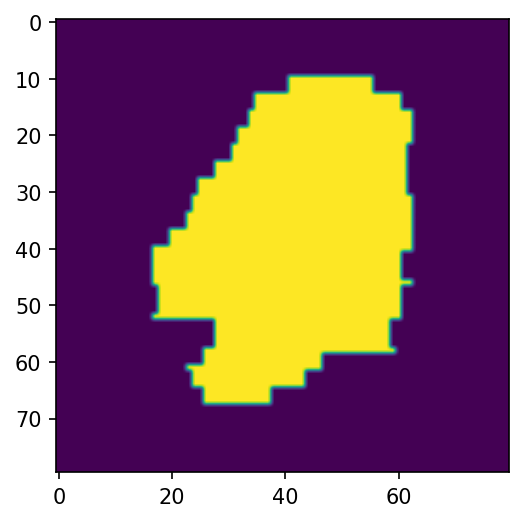

In [244]:
N = 256
grid_spacing = 64

grid = sitk.GridSource(
    outputPixelType=sitk.sitkFloat32,
    size=(N, N, N),
    sigma=(0.5, 0.5, 0.5),
    gridSpacing=(grid_spacing, grid_spacing, grid_spacing),
    gridOffset=(0, 0, 0),
    spacing=(1, 1, 1),
)

im = sitk.GetArrayViewFromImage(img_mhd)
fig, ax = plt.subplots(dpi=150)
ax.imshow(
    im[:,:,40],
    interpolation='hamming',
)

(71933, 3) (71933, 3)
[-14.00481624 -13.99208237 -13.94521525 ...  13.35155533  13.40303722
  13.42426531]


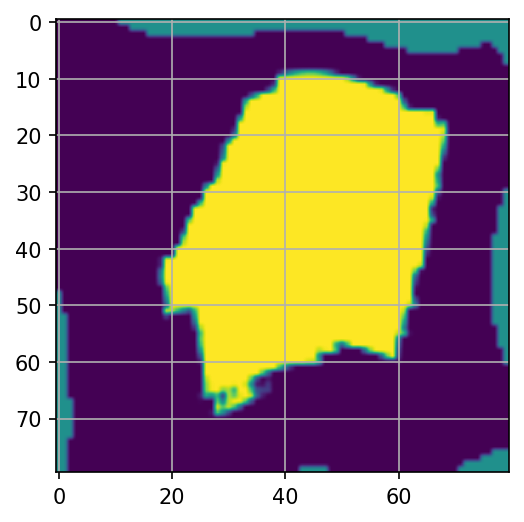

In [280]:
# ctrl_pts = 7, 7, 7
# fix_edges = 3

# ctrl_pts = np.array(ctrl_pts, np.uint32)
# SPLINE_ORDER = 3
# mesh_size = ctrl_pts - SPLINE_ORDER
# transform = sitk.BSplineTransformInitializer(img_mhd, mesh_size.tolist())
# params = transform.GetParameters()

numcontrolpoints, stdDef = 5, 10

transfromDomainMeshSize=[numcontrolpoints]*img_mhd.GetDimension()

transform = sitk.BSplineTransformInitializer(img_mhd,transfromDomainMeshSize)

params = tx.GetParameters()

paramsNp= np.asarray(params,dtype=float)
paramsNp = paramsNp + np.random.randn(paramsNp.shape[0])*stdDef

#     paramsNp[0:int(len(params)/3)]=0 #along z deformation
#     paramsNp[int(len(params)/3):int(len(params)*2/3)]=0 # along y deformation
#     paramsNp[int(len(params)*2/3):]=0 # along x deformation

params=tuple(paramsNp)
transform.SetParameters(params)

resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(img_mhd)
resampler.SetTransform(transform)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(0.5)
resampler.SetOutputPixelType(sitk.sitkFloat32)
resampled = resampler.Execute(img_mhd)

array = sitk.GetArrayViewFromImage(resampled)

fig, ax = plt.subplots(dpi=150)
ax.grid()
ax.imshow(
    array[:,:,40],
    #extent=[
    #    0, resampled.GetSize()[1] * resampled.GetSpacing()[1],
    #    0, resampled.GetSize()[0] * resampled.GetSpacing()[0],
    #],
    interpolation='hamming',
)


displacementField = sitk.TransformToDisplacementField(transform, 
                                  sitk.sitkVectorFloat64,
                                  resampled.GetSize(),
                                  resampled.GetOrigin(),
                                  resampled.GetSpacing(),
                                  resampled.GetDirection())
imm = sitk.GetArrayFromImage(displacementField)
# print(imm)
imm[:,:,:,0] = np.multiply(im,imm[:,:,:,0])
imm[:,:,:,1] = np.multiply(im,imm[:,:,:,1])
imm[:,:,:,2] = np.multiply(im,imm[:,:,:,2])
print(get_pc(imm[:,:,:,2]).shape, get_pc(im).shape)
dvf = []
for i in imm:
    for j in i:
        for k in j:
            dvf.append(k)
            
print(np.unique(dvf))
# TODO:
# np.multply(mask, imm)
# extract them as pointclods
# define the loss thing
# and then we start on the data
#

# dft = sitk.DisplacementFieldTransform(transform)
# img = displacementField.GetDisplacementField()
# sitk.WriteImage(img, "my_displacement_field.nii")
# print(displacementField)
# sitk.WriteTransform(displacementField, "deformation_field.txt")